# Training of Vision Transformer for Brain Tumor Classification

Construct MRI data pipeline that pre-process and augment brain images; train a Vision Transformer, ViT -based classification model on labeled images with and without brain tumors; use trained model for inference and plot a confusion matrix.

In [ ]:
!pip install datasets transformers torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install torch

Check if GPU is being used

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Jan  6 19:49:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ColabNotebooks/ExplainableAI

/content/drive/MyDrive/ColabNotebooks/ExplainableAI


In [ ]:
import glob
import pandas as pd
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


## 1. Load and split MRI dataset

Load dataset using Hugging Face datasets library

### Set datasets paths

In [ ]:
from datasets import load_dataset, Image

# Huggingface datasets load_dataset loads local files and split
data = load_dataset("imagefolder", data_dir="mri_data_full")

Resolving data files:   0%|          | 0/2934 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/711 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# count files in folder and subfolders
!find mri_data_full | wc -l

3655


In [ ]:
# Huggingface datasets.load_data accumulates all image files in directory and
# subdirectories and splits into train and test datasets
print(type(data))
#display alll key's in dictionary
print(data.keys())
# display the first few key value pairs from dictionary
print(list(data.items())[:5])
# display length of datasets.Dataset
print(f"Length of training dataset: {len(data['train'])}")
print(f"Length of test dataset: {len(data['test'])}")

<class 'datasets.dataset_dict.DatasetDict'>
dict_keys(['train', 'test'])
[('train', Dataset({
    features: ['image', 'label'],
    num_rows: 2934
})), ('test', Dataset({
    features: ['image', 'label'],
    num_rows: 711
}))]
Length of training dataset: 2934
Length of test dataset: 711


In [ ]:
# Extract and map labels from datasets onto images
print(data["train"].features["label"].names)

['notumor', 'tumor']


### Convert class names notumor and tumor to numerical labels

In [ ]:
# labels as a list of two possible values [['notumor', 'tumor']
labels = data["train"].features["label"].names

label2id = dict()
id2label = dict()

# create mappings between label names and indices
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# print the label names corresponding to indices 0 and 1
print(id2label[str(0)], id2label[str(1)])

notumor tumor


### Display random image from training and test sets

In [ ]:
# print dictionary key value pairs
print(list(data.items()))

[('train', Dataset({
    features: ['image', 'label'],
    num_rows: 2934
})), ('test', Dataset({
    features: ['image', 'label'],
    num_rows: 711
}))]


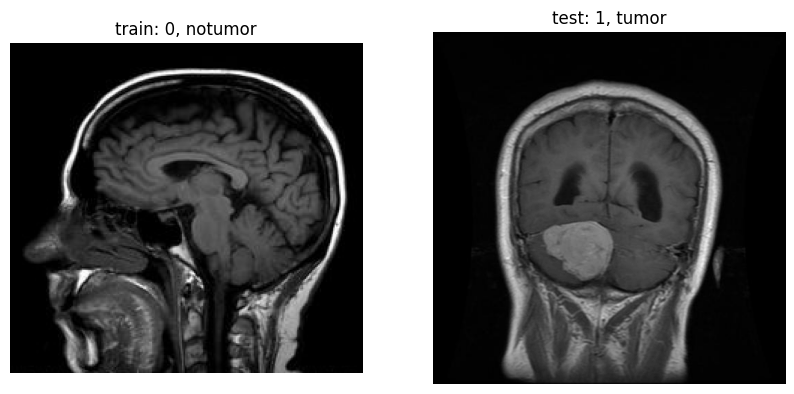

In [ ]:
def display_random_image(data, ds_name, ax=None):
  """Function that displays a random image from the dataset on the specified axes,
     with image's class name and integer label."""

  random_index = random.randint(0, len(data[ds_name]))

  img = data[ds_name][random_index]['image']
  img_label = data[ds_name][random_index]['label']
  img_int_label = id2label[str(img_label)]


  # use ax if provided, otherwise use plt
  if ax is not None:
    ax.axis('off')  # remove axes and ticks
    ax.set_title(f"{ds_name}: {img_label}, {img_int_label}")
    ax.imshow(img, cmap='gray')
  else:
    plt.axis('off')
    plt.title(f"{ds_name}: {img_label}, {img_int_label}")
    plt.imshow(img)
    plt.show()

# create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display random images from test and train datasets on each subplot
display_random_image(data, "train", ax=axs[0])
display_random_image(data, "test", ax=axs[1])

# show the figure with both images
plt.show()

In [ ]:
# get pixel size of random image in 2D, i.e. GRAYSCALE img
random_index = random.randint(0, len(data['train']))
img = data['train'][random_index]['image']
# get pixel size of img as an numpy array
np.array(img).shape

(512, 512)

## 2. Set up ViT image processor

From Hugging Face Transformers library load a pre-trained image processor, which can normalize images and convert them to tensors

Vit models are trained with specific transformations applied to images fed into them. Make sure the same transformations are used to pre-prcess the training and testing images; display ViTImageProcessor configuration, saved along with the pre-trained model.<br>
Inorder to apply ViT transformations to the grapy scale images, converto to RGB

In [ ]:
from transformers import AutoImageProcessor

# get the weights of the image processor
checkpoint = "google/vit-base-patch16-224-in21k"

# load the image processor
processor = AutoImageProcessor.from_pretrained(checkpoint)
print(f"Image processor configuration:\n {processor}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Image processor configuration:
 ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



To process an image, pass it to the image processor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.

In [ ]:
# process the first training image returning a torch tensors, with "RGB" chanel, set return_tensors="pt", defaut numpy arrays
processor(data['train'][0]['image'], return_tensors="pt")
print(f"The shape of the image tensor: {processor(data['train'][0]['image'], return_tensors='pt')['pixel_values'].shape}")

The shape of the image tensor: torch.Size([1, 3, 224, 224])


In [ ]:
print(f"The image processor will normalize images using its mean and std parameters:\n image processor mean = {processor.image_mean}, image processor std = {processor.image_std}")

The image processor will normalize images using its mean and std parameters:
 image processor mean = [0.5, 0.5, 0.5], image processor std = [0.5, 0.5, 0.5]


## 3. Data Augmentation, Normalization and Convertion into Tensors

### Augmantation Function

A function that applys random flip/rotate, zoomin, crop to train, test and validate data

In [ ]:
processor.image_mean[0]

0.5

In [ ]:
import torchvision.transforms as T
from transformers import DefaultDataCollator # used for collating data into batches


# set size for random resized crop, checks if the image processor
# has a "shortest_edge" defined in its configuration. If so, it uses it as the
# size. Otherwise, it uses the "height" and "width" defined in the image_processor.
size = (
    processor.size["shortest_edge"]
    if "shortest_edge" in processor.size
    else (processor.size["height"], processor.size["width"])
)

# normalize images based on mean and std provided by the pretrained model,
# use only one chanel since process data in gray scale vs RGB
normalize = T.Normalize(
    mean = processor.image_mean[0],
    std = processor.image_std[0])

# data augmentation for training
train_data_augmentation = T.Compose([
    # Resize the image before cropping to ensure it's large enough
    T.Resize((size[0], size[1])),  # resize to (224, 224) or the shortest edge size
    T.RandomCrop(size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=4.57),  # approximately equivalent to factor=0.02
    T.RandomResizedCrop(size=size, scale=(0.8, 1.2)),  # Simulating RandomZoom
    T.ToTensor(),
    normalize
    ]
)

# data augmentation for validation
val_data_augmentation = T.Compose([
    T.CenterCrop(size),
    T.ToTensor(),
    normalize
])

### Augment Datasets

In [ ]:
def process_train_batch(batch):
  """ Read an bath of train images and transform them into inputs.
      Since transformer is pre-trained on RGB images convert from gray scale"""
  batch_inputs = [train_data_augmentation(img.convert("RGB")) for img in batch['image']]
  # return a dictionary with image and label data
  return {'image': batch_inputs, 'labels': batch['label']}

In [ ]:
def process_val_batch(batch):
  """ Read an bath of test images and transform them into inputs. """
  batch_inputs = [val_data_augmentation(img.convert("RGB")) for img in batch['image']]
  # return a dictionary with image and label data
  return {'image': batch_inputs, 'labels': batch['label']}

Transform the dataset while indexing every example in a batch

In [ ]:
# set the transformation functions for training and validation datasets
# NB: set_transform does sets up a function to be applied on-the-fly for example
# during training in a DataLoader for memory efficiency
data["train"].set_transform(process_train_batch)
data["test"].set_transform(process_val_batch)

In [ ]:
# pixel values of a random image should be normalized aprox between -1 and 1
idx = random.randint(0, data['train'].num_rows-1)
print(f"The min value of the pixel values tensor: {data['train'][idx]['image'].min()}")
print(f"The max value of the pixel values tensor: {data['train'][idx]['image'].max()}")

The min value of the pixel values tensor: -1.0
The max value of the pixel values tensor: 1.0


In [ ]:
# set the data colllator which is responsible for taking a batch of transformed
# data and assembling them into PyTorch tensors
data_collator = DefaultDataCollator(return_tensors="pt")

## 4. Classification accuracy

**Confusion matrix** which describes the model performance fromm different angles: <br><br>

|        | Predicted Tumor | Predicted Normal |
| :----- | :-------------: | ---------------: |
| Tumor  |       TP        |       FN         |
| Normal |       FP        |       TN         |

**Recall**, aka **Sensitivity** is how images withtumor were incorrectlydiagnosed <br>
<p align="center">
$Recall$ = $\frac{TP}{TP + FN}$ <br><br>
</p>

**Precision**, aka **Specificity** is how many of the normal images were diagnosed as tumor <br>
<p align="center">
$Precosion$ = $\frac{TP}{TP + FP}$ <br><br>
</p>

**F-score** summarizes the performance of a classifier with a single metric as a *harmonic mean* of recall $r$ and precision $p$: <br>
<p align="center">
$F-score$ = $\frac{2pr}{p + r}$
</p>
<br>
High Recall means the model is good at identifing tumors on mri images. A high precision means the model is making accurate tumor predictions and isn't raising false alarms too often.A high F1 score indicates that the model is performing well in terms of both finding tumors (recall) and making accurate tumor predictions (precision).

In [ ]:
def calculate_metrics(predictions, labels):
    """
    Function to calculate accuracy, recall, precision, and F1 score, returning dictionary
    containing these metrics.
    """

    # Calculate True Positives (TP), False Positives (FP),
    # True Negatives (TN), and False Negatives (FN)
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for pred, true in zip(predictions, labels):
        if pred == 1 and true == 1:
            TP += 1
        elif pred == 1 and true == 0:
            FP += 1
        elif pred == 0 and true == 0:
            TN += 1
        elif pred == 0 and true == 1:
            FN += 1

    # calculate accuracy, recall, precision, and F1 score
    accuracy = (TP + TN)/(TP + FP + TN + FN) if (TP + FP + TN + FN) != 0 else 0
    recall = TP/(TP + FN) if (TP + FN) != 0 else 0
    precision = TP/(TP + FP) if (TP + FP) != 0 else 0
    f1 = 2 * (precision * recall)/(precision + recall) if (precision + recall) != 0 else 0

    # Return the metrics as a dictionary
    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}


## 5. Load and Train ViT classification model

ViT model consists of a BERT-like encoder and a linear classification head on top of the last hidden state of the Classification token. Each image is split into a sequence of non-overlapping patches (of resolutions like 16x16 or 32x32), which are linearly embedded, absolute position embeddings are added, and sent through a stack of encoder layers. A classification token is added at the beginning in order to get a representation of the entire image. A linear classification head can be added on top of the final hidden state in order to classify images.



### Instnatiate pre-trained ViT classification model

In [ ]:
import torch
from transformers import ViTForImageClassification

# loading a pretrained model includes the cross-entropy loss function
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    attn_implementation="sdpa",
    num_labels=2,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Set up optimizer and a learning rate schedule

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import create_optimizer

batch_size = 64 #32 #16
num_epochs = 3
# calculate num_training_steps as the number of batches,
# an integer (floor) division by the batch_size, times the num_epochs
num_training_steps = (len(data['train'])//batch_size) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01


# create optimizer and learning rate schedule
#optimizer, lr_schedule = create_optimizer(
    #init_lr = learning_rate,
    #num_train_steps = num_training_steps,
    #weight_decay_rate = weight_decay_rate,
    #num_warmup_steps = 0
#)

# Use AdamW instead of create_optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  weight_decay = weight_decay_rate)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(f"Number of training steps is {(len(data['train'])//batch_size) * num_epochs}")

Number of training steps is 2745


### Forward pass the training data

### TensorBoard callbacks

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# create a TensorBoard SummaryWriter
writer = SummaryWriter()

### Run training

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Lazy transformation happens on the fly right before the batch is
# requested by the DataLoader, i.e. the original dataset remains unchanged
# the tranformed data can be access through the keys in the batch dictionary
train_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
  # Initialize lists to store predictions and labels for the epoch
    all_predictions = []
    all_labels = []
    print(f"======================= Epoch: {epoch + 1} ========================")
    print()

    #for batch in train_loader:
    for batch_index, batch in enumerate(train_loader):
        # access the preprocessed pixel values
        inputs = batch['image'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        # providing the labels to the model call, it callulates the loss using
        # the default loss used to pre-trained, the outputs obj contains the loss
        # outputs = model(pixel_values=inputs, labels=labels)
        # models calculates the loss based on raw outputs before softmax (logits) and the true labels
        # loss = outputs.loss

        outputs = model(pixel_values=inputs)
        # compute loss explicitly
        loss = F.cross_entropy(outputs.logits, labels)

        # print out the loss
        print(f"Batch number: {batch_index} Loss: {loss.item()}")
        # backpropagate the loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # gather predictions for the batch
        _, preds = torch.max(outputs.logits, 1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # for each epoch calculate evaluation metrics with custom function
    metrics = calculate_metrics(all_predictions, all_labels)
    print()
    for key, value in metrics.items():
      # log metrics to TensorBoard
      writer.add_scalar(f'Metrics/{key}', value, epoch)
      print(f'{key}, {value:.4}')


    #print(f"accucary: {metrics['accuracy']:.4f}, recall:, {metrics['recall']:.4f}, precision:, {metrics['precision']:.4f}, f1:, {metrics['f1']:.4f}")


======================= Epoch: 1 ========================

Batch number: 0 Loss: 0.0007114278269000351
Batch number: 1 Loss: 0.0004093907482456416
Batch number: 2 Loss: 0.0004975922638550401
Batch number: 3 Loss: 0.0014605087926611304
Batch number: 4 Loss: 0.0005424857372418046
Batch number: 5 Loss: 0.0010873973369598389
Batch number: 6 Loss: 0.047452136874198914
Batch number: 7 Loss: 0.00029744379571639
Batch number: 8 Loss: 0.09825696796178818
Batch number: 9 Loss: 0.0011724040377885103
Batch number: 10 Loss: 0.00026084398268722
Batch number: 11 Loss: 0.00020003123790957034
Batch number: 12 Loss: 0.0004887999384663999
Batch number: 13 Loss: 0.0003841007128357887
Batch number: 14 Loss: 0.0027933793608099222
Batch number: 15 Loss: 0.0005044410354457796
Batch number: 16 Loss: 0.0002163474855478853
Batch number: 17 Loss: 0.008873672224581242
Batch number: 18 Loss: 0.00037105512456037104
Batch number: 19 Loss: 0.0002003865665756166
Batch number: 20 Loss: 0.0004513020103331655
Batch number

In [ ]:
# save model parameters
torch.save(model.state_dict(), 'model_parameters.pth')
# load trained model parameters
model.load_state_dict(torch.load('model_parameters.pth'))

In [ ]:
# after ot during training loop start TensorBoard to view logged data
%load_ext tensorboard
%tensorboard --logdir runs

### Run the model on test data

The model is set to evaluation mode with model.eval(). The code iterates through the test_loader, gets the model's predictions, and stores them along with the true labels.

In [ ]:
# create the test data loader
test_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=False)

# run inference on the test data
all_predictions = []
all_labels = []
# set the model to evaluation mode
model.eval()
# disable gradient calculation during inference
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs, labels=labels)
        _, preds = torch.max(outputs.logits, 1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

metrics = calculate_metrics(all_predictions, all_labels)

for key, value in metrics.items():
  writer.add_scalar(f'Metrics/{key}', value, epoch)
  print(f'{key}, {value:.4}')


#print(f"Testing Accucary: {metrics['accuracy']:.4f}, Testing Recall:, {metrics['recall']:.4f}, Testing Precision:, {metrics['precision']:.4f}, Testing F1 score:, {metrics['f1']:.4f}")
print(all_predictions[:10])
print(all_labels[:10])


accuracy, 0.9705
recall, 0.9314
precision, 1.0
f1, 0.9645
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Compute and plot confusion matrix

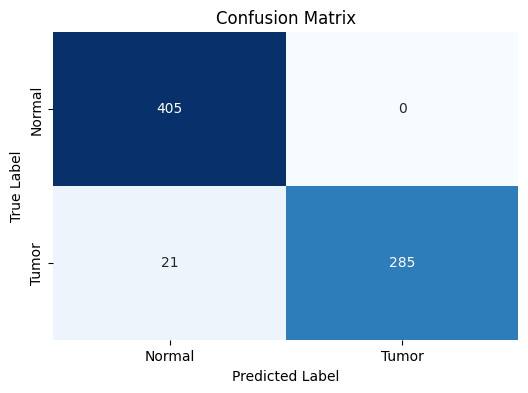

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 6. Display images with true and predicted labels

In [ ]:
data['test'][1]['image']

tensor([[[-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         [-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         [-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         ...,
         [-0.8824, -0.8824, -0.8824,  ..., -0.8980, -0.8980, -0.8902],
         [-0.8902, -0.8980, -0.8902,  ..., -0.8824, -0.8824, -0.8902],
         [-0.8902, -0.8902, -0.8902,  ..., -0.8824, -0.8824, -0.8902]],

        [[-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         [-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         [-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         ...,
         [-0.8824, -0.8824, -0.8824,  ..., -0.8980, -0.8980, -0.8902],
         [-0.8902, -0.8980, -0.8902,  ..., -0.8824, -0.8824, -0.8902],
         [-0.8902, -0.8902, -0.8902,  ..., -0.8824, -0.8824, -0.8902]],

        [[-0.8824, -0.8824, -0.8745,  ..., -0.8745, -0.8745, -0.8745],
         [-0.8824, -0.8824, -0.8745,  ..., -0

indices: [349, 441, 210, 445, 646, 220, 411, 628, 638]


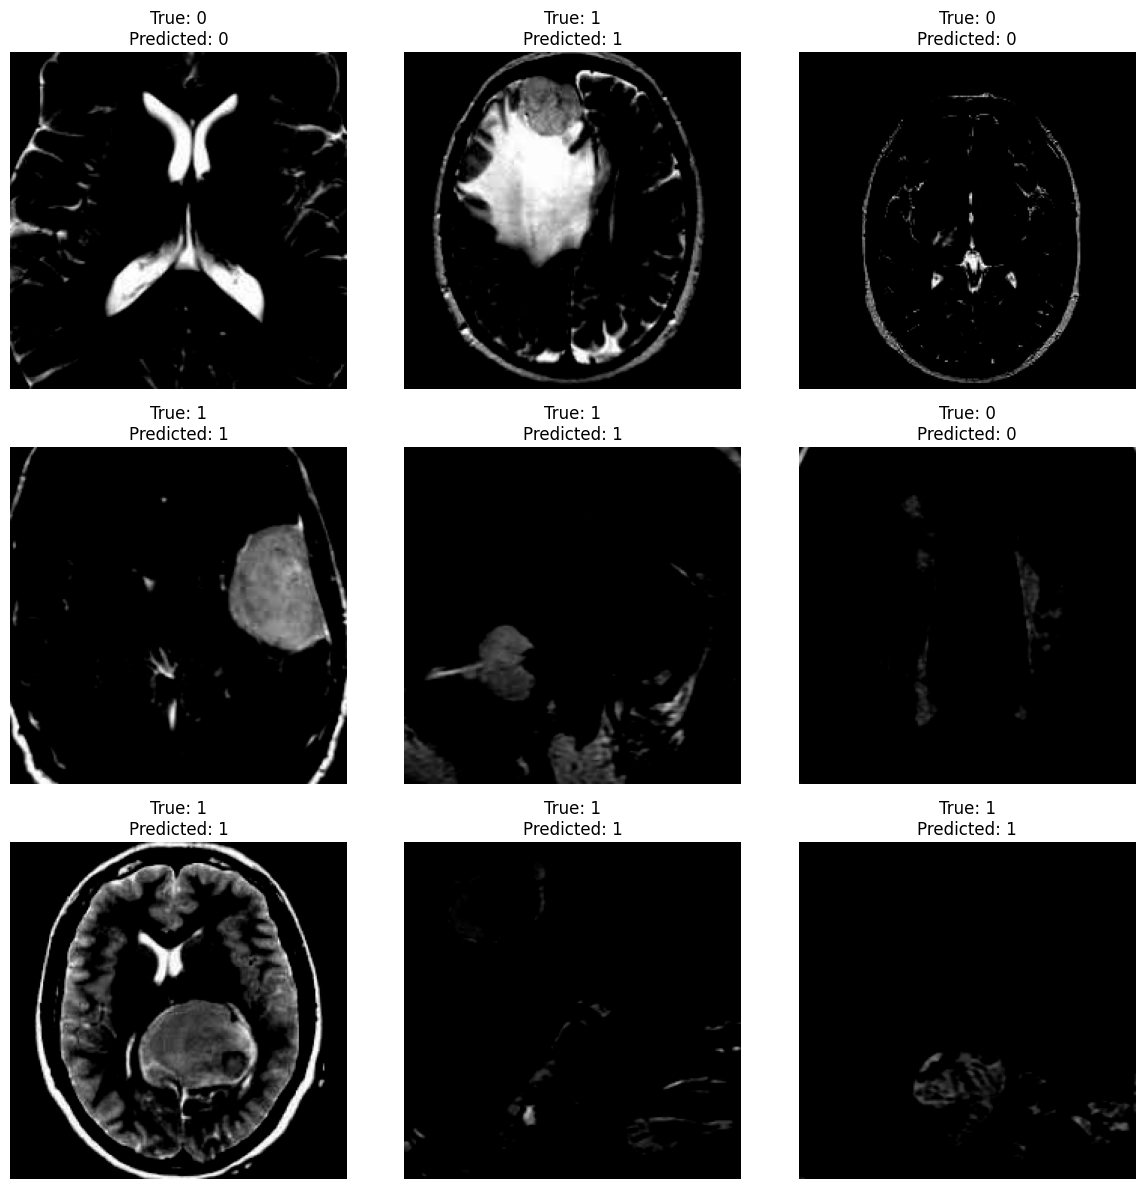

In [ ]:
# Create lists to store predicted and actual labels
pred_op = []
act_op = []

# plot 9 random test images with their predicted and actual labels
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.ravel()  # Flatten the axes array

num_samples = 9
# take 9 unique image sample from test data
indices = random.sample(range(len(data['test'])), num_samples)
print("indices:", indices)

for i, idx in enumerate(indices):
    image = data['test'][idx]['image']
    true_label = data['test'][idx]['labels']

    predicted_label = all_predictions[idx]

    pred_op.append(predicted_label)
    act_op.append(true_label)

    # Convert the image to a NumPy array and permute the dimensions
    image_np = image.permute(1, 2, 0).cpu().numpy()

    axs[i].imshow(image_np)
    axs[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()